In [1]:
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import scipy.signal as signal
import matplotlib.pyplot as plt

from carriers import sawtooth_osc, square_osc

In [2]:
# Utils
def compare_stft(a_audio, b_audio, a_name="A", b_name="B"):
    # input should be audio array (sr*time, )
    fig, axes = plt.subplots(1,2, figsize=(22,8))
    
    D = np.abs(librosa.stft(a_audio, window='hann', n_fft=n_fft, hop_length=hop_length))
    img = librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), x_axis="time", y_axis="linear", sr=sr, ax=axes[0])
    axes[0].set_title(a_name)
    plt.colorbar(img, ax=axes[0], format="%+2.f dB")

    D = np.abs(librosa.stft(b_audio, window='hann', n_fft=n_fft, hop_length=hop_length))
    img = librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), x_axis="time", y_axis="linear", sr=sr, ax=axes[1])
    axes[1].set_title(b_name)
    plt.colorbar(img, ax=axes[1], format="%+2.f dB")
    
    
def compare_f0(a_stft, b_stft, a_name="A", b_name="B"):
    # input should be stft
    
    def get_f0(x):
        f0, _, _ = librosa.pyin(x,
                                fmin=librosa.note_to_hz('C2'), # 1, 
                                fmax=librosa.note_to_hz('C7'), # sr * 0.5,
                                sr=sr,
                                frame_length=n_fft,
                                hop_length=hop_length)
        times = librosa.times_like(f0)
        return f0, times
    
    fig, axes = plt.subplots(1,2, figsize=(22,8))
    
    f0, times = get_f0(librosa.istft(librosa.phase_vocoder(a_stft, rate=1.0, hop_length=hop_length)))
    D = librosa.amplitude_to_db(np.abs(a_stft), ref=np.max)
    img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=axes[0])
    axes[0].set_title(a_name)
    plt.colorbar(img, ax=axes[0], format="%+2.f dB")
    axes[0].plot(times, f0, color='cyan', linewidth=3)
    
    f0, times = get_f0(librosa.istft(librosa.phase_vocoder(b_stft, rate=1.0, hop_length=hop_length)))
    D = librosa.amplitude_to_db(np.abs(b_stft), ref=np.max)    
    img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=axes[1])
    axes[1].set_title(b_name)
    plt.colorbar(img, ax=axes[1], format="%+2.f dB")
    axes[1].plot(times, f0, color='cyan', linewidth=3)
    

## Load Audio

In [3]:
# Audio Selection
import ipywidgets as widgets

w = widgets.Dropdown(
    options=[('dog_sound', 'dog_sound'), 
             ('suzanne', 'suzanne')],
    value='suzanne',
    description='Select audio:',
)
ipd.display(w)

Dropdown(description='Select audio:', index=1, options=(('dog_sound', 'dog_sound'), ('suzanne', 'suzanne')), v…

In [4]:
# Load Audio
sr = 44100
modulator_x, _ = librosa.load("./audio_resources/{}.wav".format(w.value), sr=sr) 
ipd.Audio(modulator_x, rate=sr)

## Basic Channel Vocoder
### 1. Band-pass filter

In [5]:
class Bandpass_Filter():
    def __init__(self, low, high, nyq, filter_type='butter', order=10):
        self.low = int(1 if low == 0 else low)
        self.high = int(nyq-1 if high == nyq else high)
        filter_types = ['butter', 'cheby1', 'bessel', 'biquad']
        if filter_type not in filter_types:
            raise ValueError(f'filter_type should be one of {filter_types}.')
        
        if filter_type == 'butter':
            self.sos = signal.butter(order, Wn=[self.low/nyq, self.high/nyq], btype='bandpass', output='sos')
        elif filter_type == 'cheby1':
            self.sos = signal.cheby1(order, rp=0.1, Wn=[self.low/nyq, self.high/nyq], btype='bandpass', output='sos')
        elif filter_type == 'bessel':
            self.sos = signal.bessel(order, Wn=[self.low/nyq, self.high/nyq], btype='bandpass', output='sos', norm='phase')
        elif filter_type == 'biquad':
            cutoff_freq = (self.low + self.high) / 2
            Q = order
            sr = 2*nyq
            # bi-quad lowpass filter -> bandpass로 바꾸기..?
            theta = 2*np.pi*cutoff_freq/sr
            alpha = np.sin(theta)/2/Q
            b = [(1-np.cos(theta)), 2*(1-np.cos(theta)), (1-np.cos(theta))]
            a = [(1+alpha), -2*np.cos(theta), (1-alpha)]
            self.sos = signal.tf2sos(b, a)
        
    def __call__(self, x):
        return signal.sosfilt(self.sos, x)

### 2. Channel Vocoder

In [6]:
class Channel_Vocoder():
    def __init__(self, n_channel, sr, n_fft=1024, freq_scale='mel', filter_type='butter'):
        self.n_channel = n_channel
        self.sr = sr
        self.hop_length = n_fft//4
        self.n_fft = n_fft
        self.freq_scale = freq_scale
        self.filter_type = filter_type
        
        nyq = sr * 0.5
        if self.freq_scale == 'linear':
            bp_range = nyq // self.n_channel
            self.bp_filters = [Bandpass_Filter(i*bp_range, (i+1)*bp_range, nyq, filter_type=self.filter_type) for i in range(self.n_channel)]
        elif self.freq_scale == 'mel':
            mel_freqs = librosa.mel_frequencies(n_mels=self.n_channel+1, fmin=0.0, fmax=nyq-1).tolist()
            self.bp_filters = [Bandpass_Filter(f0, f1, nyq, filter_type=self.filter_type) for f0, f1 in zip(mel_freqs[:-1], mel_freqs[1:])]
        
    def __call__(self, 
                 modulator_x, 
                 carrier_type='sawtooth', 
                 carrier_f0=440, 
                 beta=0.9,
                 formant_step=0,
                 high_noise=False,
                 noise_amp=1, 
                 noise_Q=1):
        # modulator_x: np.array(float), modulator source audio
        # carrier_type: (str), carrier signal shape type e.g. sine, square or sawtooth
        # carrier_f0: (int), carrier fundamental frequency
        # beta: 0.0 ~ 1.0(float), modulator-carrier ratio
        # formant_step: (int) formant shifting step
        # 준원님 여기에 노이즈 파라미터들 주석 추가해주실 수 있을까요?
        
        # Set carrier signal
        dur = modulator_x.shape[0]
        if carrier_type == 'sawtooth':
            carrier_x = sawtooth_osc(f0=carrier_f0, dur=dur, sr=self.sr)
        elif carrier_type == 'square':
            carrier_x = square_osc(f0=carrier_f0, dur=dur, sr=self.sr)
        else:
            print("Carrier Type Error")
        
        # high-freq noise
        if high_noise:
            if not (noise_amp > 0 and noise_amp <= 1):
                raise ValueError('noise_amp should be in range (0,1)')
            rand_noise = (np.random.rand(dur)-0.5)*2*noise_amp
            
            # bi-quad highpass filter
            cut_off_freq = (8e3 + 16e3)//2
            Q = noise_Q

            theta = 2*np.pi*cut_off_freq/sr
            alpha = np.sin(theta)/2/Q
            b = [(1+np.cos(theta)), -2*(1+np.cos(theta)), (1+np.cos(theta))]
            a = [(1+alpha), -2*np.cos(theta), (1-alpha)]
            rand_noise = signal.lfilter(b,a,rand_noise)
            
            carrier_x = carrier_x + rand_noise
            
            # clipping
            if any(carrier_x > 1):
                carrier_x[carrier_x>1] = 1
            if any(carrier_x < -1):
                carrier_x[carrier_x<-1] = -1
        
        # Channel Vocoding
        y = np.zeros((self.n_fft//2 + 1, modulator_x.shape[0]//self.hop_length + 1))
        for channel_idx in range(self.n_channel):
            # Band-pass (Formant shifting)
            carrier_channel_idx = int((channel_idx + formant_step) % self.n_channel)
            modulator_block = self.bp_filters[channel_idx](modulator_x)
            carrier_block = self.bp_filters[carrier_channel_idx](carrier_x)
            
            # RMS & STFT
            modulator_rms = librosa.feature.rms(y=modulator_block, hop_length=self.hop_length)
            carrier_block = librosa.stft(carrier_block, window='hann', n_fft=self.n_fft, hop_length=self.hop_length)
            
            # Multipy and stack it
            y = np.add(y, np.multiply(beta*modulator_rms, (1-beta)*carrier_block), casting='unsafe')
        return librosa.istft(y)

    
class Bandpass_Filter():
    def __init__(self, low, high, nyq, filter_type='butter', order=10):
        self.low = int(1 if low == 0 else low)
        self.high = int(nyq-1 if high == nyq else high)
        filter_types = ['butter', 'cheby1', 'bessel', 'biquad']
        if filter_type not in filter_types:
            raise ValueError(f'filter_type should be one of {filter_types}.')
        
        if filter_type == 'butter':
            self.sos = signal.butter(order, Wn=[self.low/nyq, self.high/nyq], btype='bandpass', output='sos')
        elif filter_type == 'cheby1':
            self.sos = signal.cheby1(order, rp=0.1, Wn=[self.low/nyq, self.high/nyq], btype='bandpass', output='sos')
        elif filter_type == 'bessel':
            self.sos = signal.bessel(order, Wn=[self.low/nyq, self.high/nyq], btype='bandpass', output='sos', norm='phase')
        elif filter_type == 'biquad':
            cutoff_freq = (self.low + self.high) / 2
            Q = order
            sr = 2*nyq
            # bi-quad lowpass filter -> bandpass로 바꾸기..?
            theta = 2*np.pi*cutoff_freq/sr
            alpha = np.sin(theta)/2/Q
            b = [(1-np.cos(theta)), 2*(1-np.cos(theta)), (1-np.cos(theta))]
            a = [(1+alpha), -2*np.cos(theta), (1-alpha)]
            self.sos = signal.tf2sos(b, a)
        
    def __call__(self, x):
        return signal.sosfilt(self.sos, x)
        

## Test Sample

In [7]:
n_fft = 512
hop_length = n_fft//4

channel_vocoder = Channel_Vocoder(n_channel=50, sr=sr, n_fft=n_fft, freq_scale='mel')
output = channel_vocoder(modulator_x, carrier_type='sawtooth', carrier_f0=440, formant_step=0)
ipd.Audio(output, rate=sr)

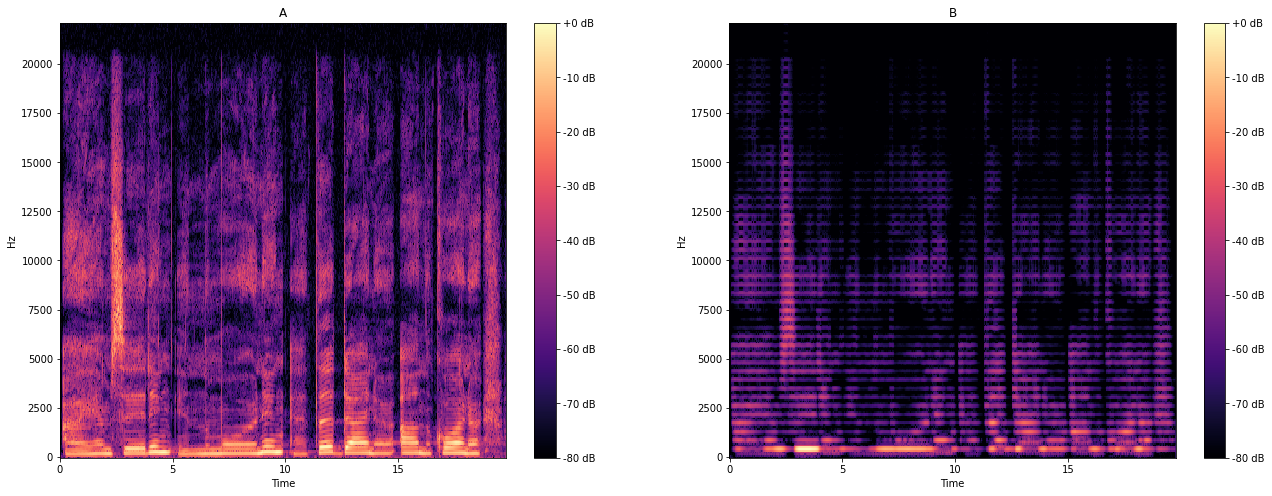

In [8]:
compare_stft(modulator_x, output)

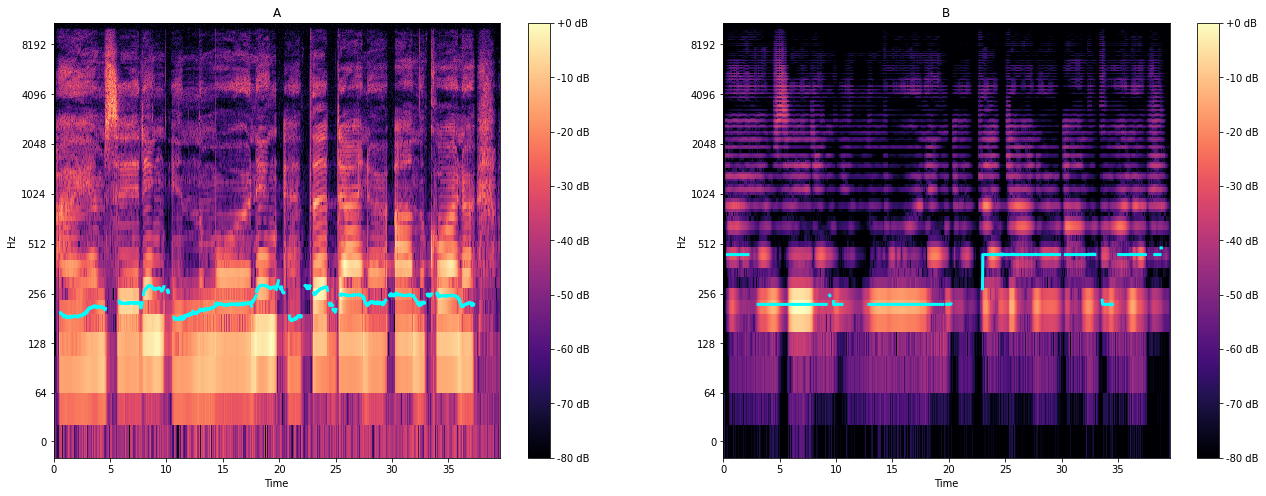

In [9]:
# compare original and vocoded sound
origin_stft = librosa.stft(modulator_x, window='hann', n_fft=n_fft, hop_length=hop_length)
vocoded_stft = librosa.stft(output, window='hann', n_fft=n_fft, hop_length=hop_length)
compare_f0(origin_stft, vocoded_stft)

In [10]:
# Deprecated (Just in case)
def stft_f0_shift_to_mean(x):
    D = (librosa.stft(x,window='hann', n_fft=n_fft, hop_length=hop_length)).T
    f0, _, _ = librosa.pyin(x,
                     fmin=librosa.note_to_hz('C2'), # 1, 
                     fmax=librosa.note_to_hz('C7'), # sr * 0.5,
                     sr=sr,
                     frame_length=n_fft,
                     hop_length=hop_length)
    f0_mean = np.nanmean(f0)
    
    for i in range(f0.shape[0]):
        if not np.isnan(f0[i]):
            D[i] += f0_mean - f0[i]
        
    return D.T